In [2]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Embedding, Input,LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/PBL6/preprocess7k.csv')

In [4]:
df = data[['Title', 'URL', 'preprocess_SW', 'Label']].copy()
df = df.dropna()

In [5]:
df.describe()

,Label
count,7348.000000
mean,0.542324
std,0.498239
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
path = '/content/drive/MyDrive/PBL6'

EMBEDDING_FILE=f'{path}/glove.6B.50d.txt'

# configuration setting
MAX_SEQUENCE_LENGTH = 2500
MAX_VOCAB_SIZE = 5000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [7]:
df.head(3)

,Title,URL,preprocess_SW,Label
0,LÝ DO EXONMOBIL CÓ THỂ RỜI KHỎI VIỆT NAM (Tim ...,https://www.khoi8406.com/post/nhanquyenchovn/l...,cầm_quyền tập_cận_bình đẩy_mạnh hiện_diện trun...,1
1,TỔNG THỐNG TRUMP PHẢI TRẢ ĐŨA IRAN (Ngô Nhân D...,https://www.khoi8406.com/post/nhanquyenchovn/t...,iran chủ_mưu vụ tấn_công mấy nhà_máy lọc dầu ả...,1
2,ĐẢNG CỘNG SẢN TRUNG QUỐC SẼ SỤP ĐỔ TRƯỚC NĂM 2...,https://www.khoi8406.com/post/nhanquyenchovn/a...,kỷ_niệm thành_lập cộng_hòa nhân_dân trung_hoa ...,1


In [8]:
y = df['Label']
X = df.drop(['Label','Title','URL'], axis = 1)

In [9]:
y.shape

(7348,)

Word to vector

In [10]:
word2vec = {}
with open(EMBEDDING_FILE) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [11]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(list(X['preprocess_SW']))
X = tokenizer.texts_to_sequences(list(X['preprocess_SW']))

# pad sequences so that we get a N x T matrix
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (7348, 2500)


In [12]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 36038 unique tokens.


Embedding matrix

In [13]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [14]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

Build model

In [15]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2500)]            0         
                                                                 
 embedding (Embedding)       (None, 2500, 50)          250000    
                                                                 
 bidirectional (Bidirection  (None, 2500, 30)          7920      
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 30)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 257951 (1007.62 KB)
Trainable params: 7951 (31.

Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

Run model

In [17]:
r = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/10
147/147 [==============================] - 30s 130ms/step - loss: 0.6156 - accuracy: 0.7006 - val_loss: 0.5357 - val_accuracy: 0.7925
Epoch 2/10
147/147 [==============================] - 17s 118ms/step - loss: 0.4809 - accuracy: 0.7924 - val_loss: 0.4467 - val_accuracy: 0.7959
Epoch 3/10
147/147 [==============================] - 17s 117ms/step - loss: 0.4050 - accuracy: 0.8330 - val_loss: 0.3889 - val_accuracy: 0.8316
Epoch 4/10
147/147 [==============================] - 18s 123ms/step - loss: 0.3642 - accuracy: 0.8452 - val_loss: 0.3581 - val_accuracy: 0.8478
Epoch 5/10
147/147 [==============================] - 22s 147ms/step - loss: 0.3355 - accuracy: 0.8650 - val_loss: 0.3298 - val_accuracy: 0.8631
Epoch 6/10
147/147 [==============================] - 26s 174ms/step - loss: 0.2980 - accuracy: 0.8792 - val_loss: 0.3043 - val_accuracy: 0.8707
Epoch 7/10
147/147 [==============================] - 30s 205ms/step - loss: 0.2745 - accuracy: 0.8875 - val_loss: 0.2987 - val_ac

Accuracy and Loss Function

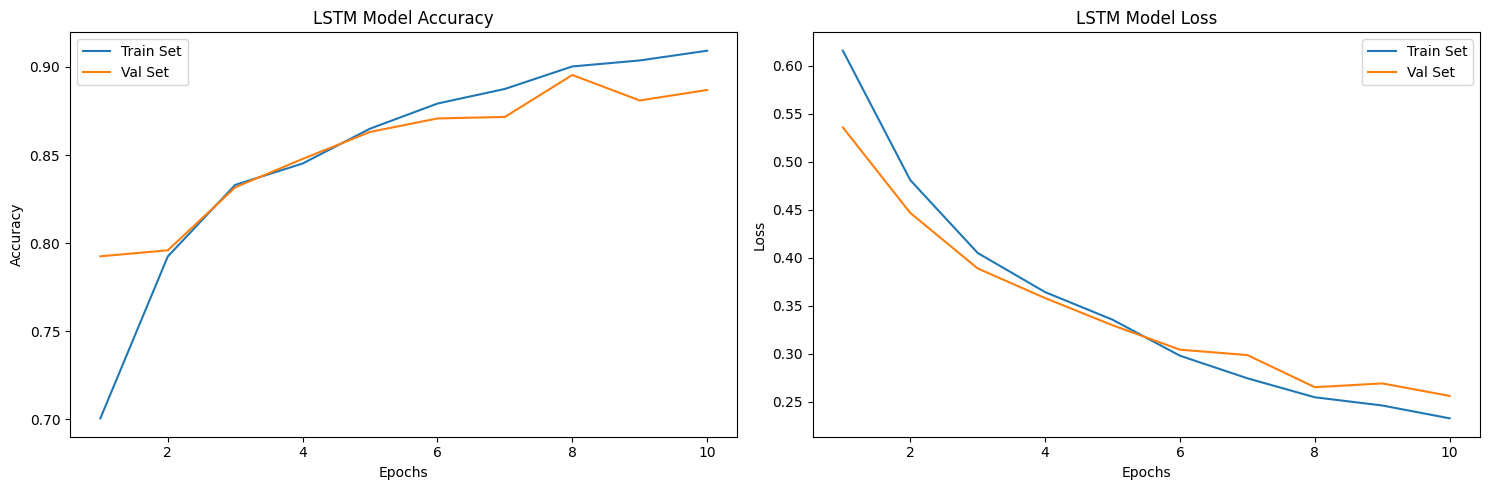

In [18]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs_range = range(1, len(r.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')

plt.tight_layout()
plt.show()

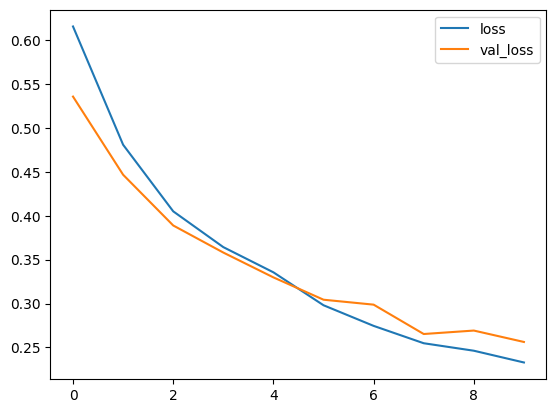

In [19]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

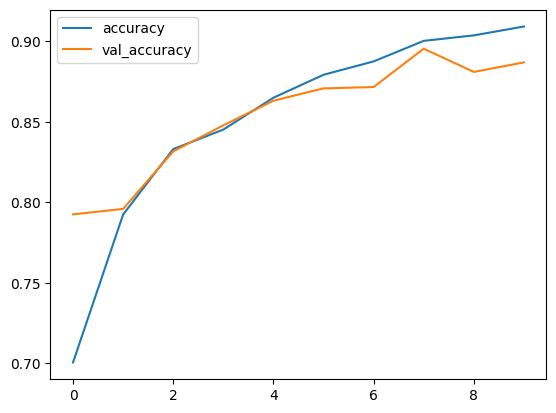

In [20]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [21]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

184/184 [==============================] - 10s 52ms/step - loss: 0.2150 - accuracy: 0.9171
Accuracy of the model on Training Data is -  91.71487092971802
46/46 [==============================] - 2s 44ms/step - loss: 0.2205 - accuracy: 0.9163
Accuracy of the model on Testing Data is -  91.63265228271484


In [22]:
pred = model.predict(X_test)
pred[:5]

46/46 [==============================] - 7s 99ms/step


array([[0.9073359 ],
       [0.07900714],
       [0.9963337 ],
       [0.06802195],
       [0.9849185 ]], dtype=float32)

**Confuse Matrix**

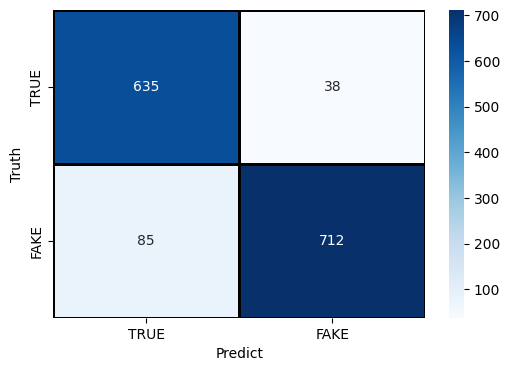

In [27]:
matrix = confusion_matrix(y_test, pred.round())
matrix = pd.DataFrame(matrix, index = ['TRUE', 'FAKE'], columns = ['TRUE', 'FAKE'])
plt.figure(figsize = (6,4))
sns.heatmap(matrix,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['TRUE','FAKE'])
plt.ylabel('Truth')
plt.xlabel('Predict')
plt.show()

In [28]:
print(classification_report(y_test,pred.round()))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       673
           1       0.95      0.89      0.92       797

    accuracy                           0.92      1470
   macro avg       0.92      0.92      0.92      1470
weighted avg       0.92      0.92      0.92      1470

